# Generative Adversarial Networks (GANs)

## Image to image generation

- Image restoration
- Start with crappified images

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

Get the oxford pets dataset and create two folders : one for original images and one for crappy counterpart.

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

### Crappifier

In [0]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True) # resized to 96x96
        # bilinear interpolation
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        # image quality of 10 is rubbish; draw the same number sampled
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

- We can also do colorization, noise etc

Run crappifier on the images

In [0]:
il = ImageList.from_folder(path_hr)
# parallel runs functions in parallel
parallel(crappifier(path_lr, path_hr), il.items) 

### Hyperparams and pretrained model

In [0]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pretrain generator

- We will use U-net
- We use ImageNet stats for normalization
- We used pretrained model since we need to know what was in the crappified location before it was crappified

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

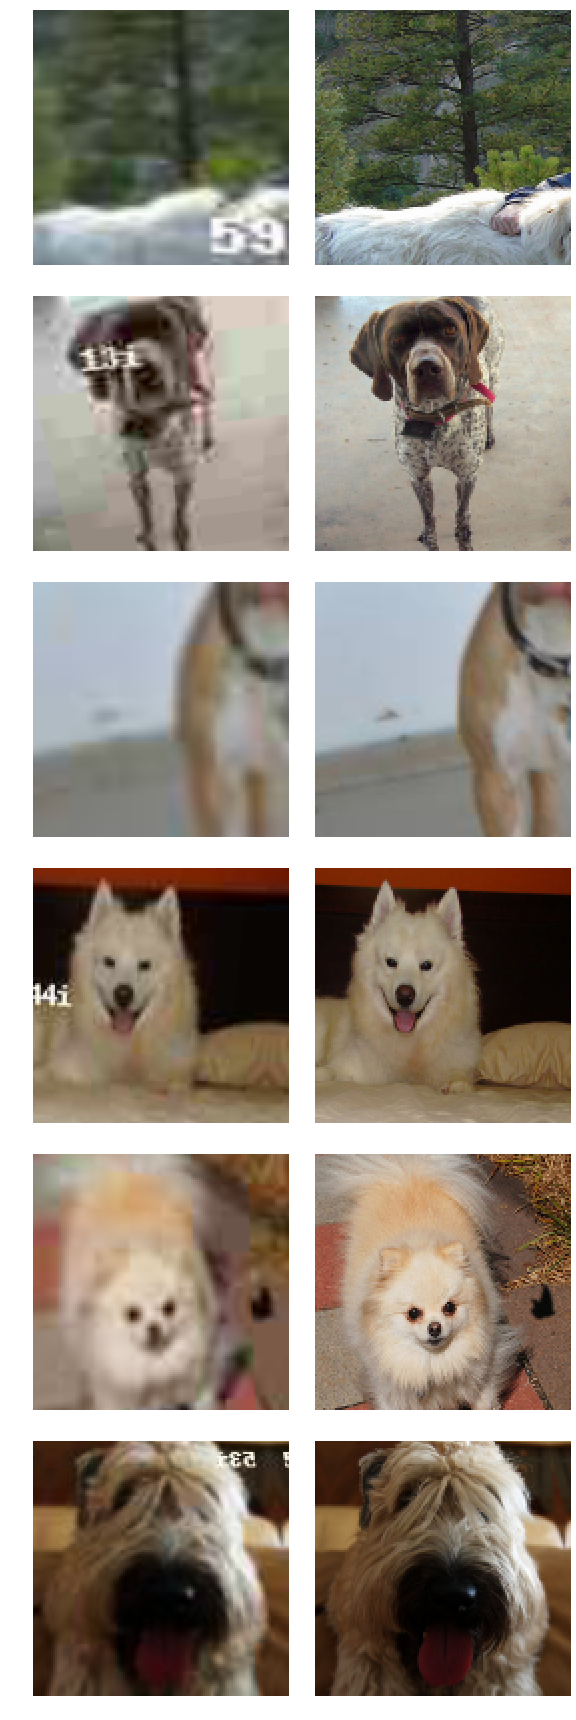

In [11]:
data_gen.show_batch(6)

In [0]:
wd = 1e-3 # weight decay

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat() # flattens to two vectors

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [16]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 118891808.96it/s]


In [17]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.065485,0.055186,03:23
1,0.053360,0.048692,03:01


> When we use transfer learning, the layers are freezed with the pretrained weights i.e in this case the downsampling part in the u-net where the resnet is 

In [0]:
learn_gen.unfreeze()

In [19]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.051326,0.048238,03:12
1,0.049120,0.045459,03:11
2,0.046950,0.044750,03:11


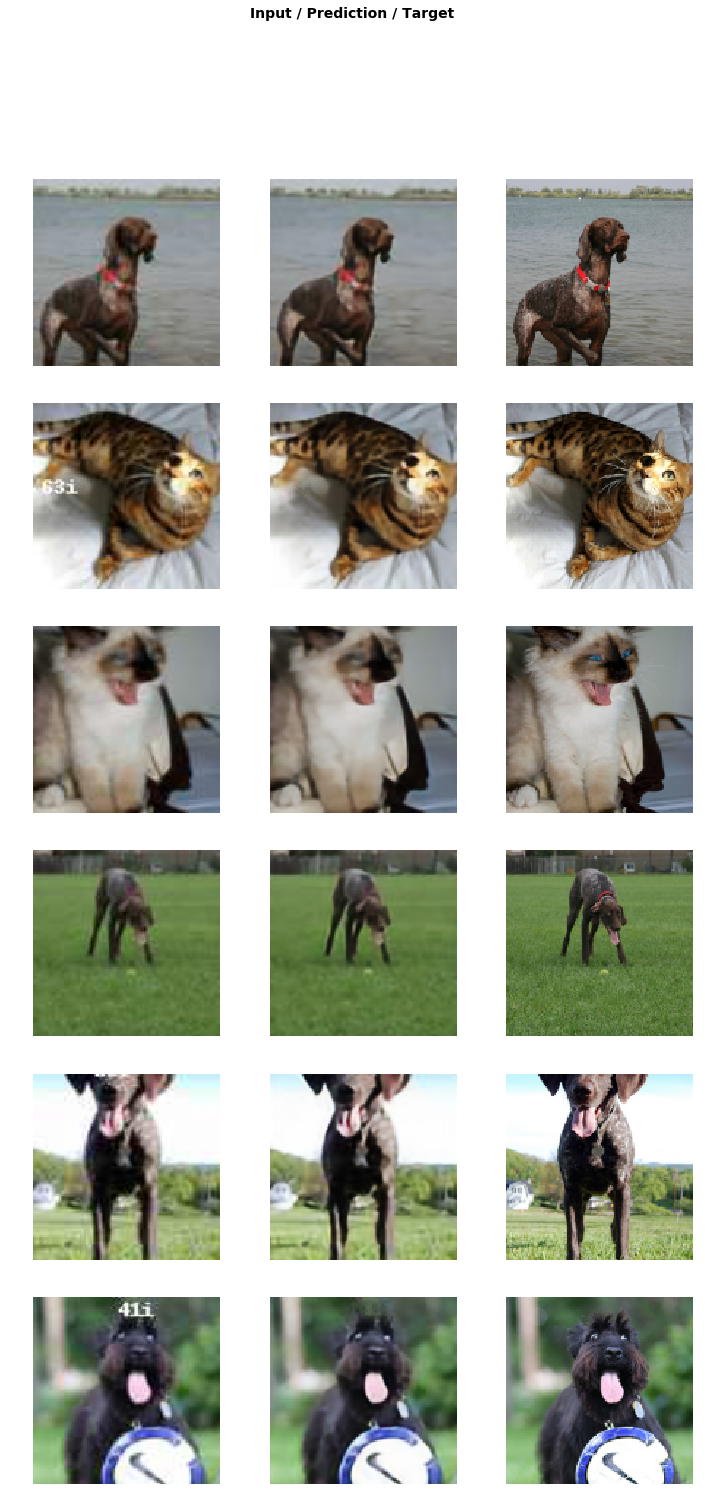

In [22]:
learn_gen.show_results(rows=6)

In [0]:
learn_gen.save('gen-pre2')

- We can observe that its removing the *watermark* jpeg artifact
- However we can also see that the output is not upsampled so much 
- The loss function i.e. MSE is very low between both of them (very nearly the same pixels)

> So we use GANs!

- We can build a discriminator that is a binary classifier : High resolution or low resolution image!
- Loss function is *Am I fooling the discriminator?*
- Train the generator to fool the discriminator
- Then train the discriminator to be better at not be fooled by the generator
- We are using pretrained generator as well as discriminator

## Save generated images

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    # takes a dataloader

    i=0
    # grab all the filenames
    names = dl.dataset.items
    
    # go through each batch of the dataloader 
    for b in dl:
        # get the predictions
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        # save the predictions
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

Example of a generated image

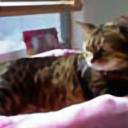

In [29]:
PIL.Image.open(path_gen.ls()[0])

## Training the Discriminator (i.e. classifier)

To clear/reclaim GPU memory

In [31]:
learn_gen = None
gc.collect()

293

Pretrain the critic on crappy vs not crappy.


In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

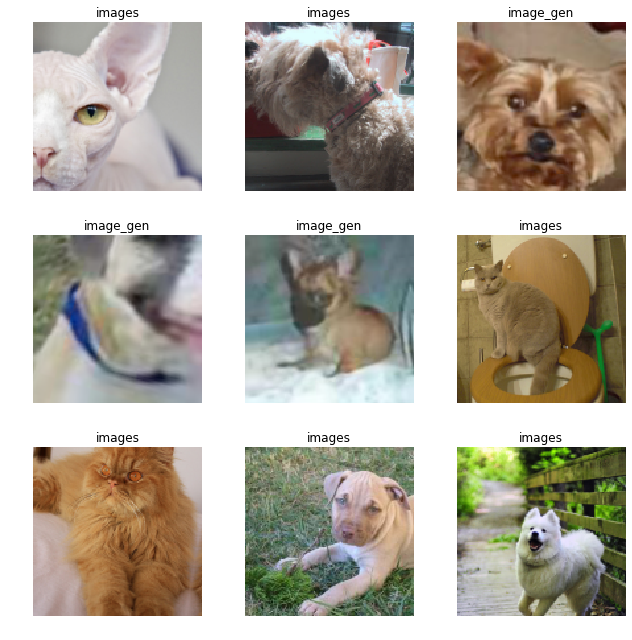

In [34]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

> We are not using a resnet for the discriminator. We use sepectral norm.

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [0]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
learn_critic.save('critic-pre2')

## GAN

We will combine both the pretrained models i.e. the generator and the discriminator in a GAN

In [0]:
learn_crit=None
learn_gen=None
gc.collect()

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')



To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by learn_crit.loss_func. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).


In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [0]:
learn.fit(40,lr)

In [0]:
learn.save('gan-1c')

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(10,lr/2)

In [0]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')